<span style="color: blue; font-size: 30px;">Contents:</span>

<hr> <!-- Horizontal Rule using HTML -->

<ol>
  <li><strong>Install & Import Dependencies</strong></li>
  <li><strong>Functions</strong></li>
  <li><strong>Proposed Architecture</strong></li>
  <li>
    <strong>Generating Datasets</strong>
    <ol>
      <li>General Data Processing</li>
      <li>RE - Realistic Evaluation (Subsection V-D)</li>
      <li>SE - Sensitivity Evaluation (Subsection V-C)</li>
    </ol>
  </li>
  <li>
    <strong>Training & Evaluation</strong>
    <ol>
      <li>RE - Realistic Evaluation</li>
      <li>SE - Sensitivity Evaluation</li>
    </ol>
  </li>
</ol>

# Install & Import dependencies

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip uninstall -y -q nilmtk nilm_metadata
!python3 -m pip install -q --no-deps git+https://github.com/nilmtk/nilmtk@master
!python3 -m pip install -q --no-deps git+https://github.com/nilmtk/nilm_metadata@master
!pip install -q tqdm

!pip install -q scikit-learn-intelex
!pip install -q xgboost

#!mamba install tensorflow-gpu==2.11.0 -y -q
!pip install -q tensorflow[and-cuda]

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from nilmtk import DataSet
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
from joblib import Memory
import pickle
from pprint import pprint

import multiprocessing as mp

from typing import Dict


from sklearn import pipeline, metrics, linear_model, model_selection, multioutput, tree, ensemble, neural_network

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import keras
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import accuracy_score
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt 

# GPU boost
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

memory = Memory(location='./cache')


import math

from keras.models import Model
from keras.layers import Flatten, Dense, Input, GRU, BatchNormalization, LSTM, Bidirectional, AveragePooling1D
from keras.layers import Conv1D, Conv1DTranspose, LocallyConnected1D, SeparableConv1D, ConvLSTM1D
from keras.layers import MaxPooling1D, Dropout
from keras.layers import GlobalMaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.preprocessing import image
#from keras.utils import layer_utils
#from keras.utils.data_utils import get_file
from keras import backend as K
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input

2024-03-08 18:17:29.880671: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 18:17:29.880746: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 18:17:29.881960: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 18:17:29.889639: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-08 18:17:30.729446: W tensorflow/compiler/tf2

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


# Functions

<p> To load raw datasets we used the following functions. They expect datasets in .hdf5 format. </p>


In [4]:
@memory.cache

def load_refit_dataset():
    try:
        dataset = DataSet('./refit.hdf5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                assert len(meter.appliances) < 2

                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e
        
def load_ukdale_dataset():
    try:
        dataset = DataSet('./ukdale.hdf5')

        samples = []
        for building_idx, building in dataset.buildings.items():
            for meter in building.elec.all_meters():

                data = list(meter.load())
                assert len(data) == 1

                sample = (building_idx, list([a.type['type'] for a in meter.appliances]), data, meter.good_sections())

                samples.append(sample)
                
        return samples

    except Exception as e:
        dataset.store.close()
        raise e

<p> The 2 cells below contain function that will be used to process data into x_train, x_test, y_train, y_test, labels format in Section 4 of this notebook. </p>

In [5]:
def data_preparation(dataset):
    X = defaultdict(lambda: [])

    for (idx, appliances, data, good_sections) in dataset:
        if not appliances:
            continue
            
        appliance = appliances[0]
        data = data[0]
    
        samples = [data[good.start:good.end] for good in good_sections]
        X[appliance].extend(samples)
        
    return X


from typing import Iterator, List, Tuple        
import multiprocessing as mp



def process(random_state):
    
    # Initialize internal seeded random number generator
    rng = np.random.default_rng(seed = random_state)
    
    # pre-allocate array for time series
    series = np.zeros(L, dtype = np.float64)

    # pre-allocate boolean array for masks
    labels = np.zeros((n_appliances, L), dtype = bool)

    # Select N random appliances (no replace, because same appliance should not appear twice in the same sample)
    for appliance_idx in rng.choice(n_appliances, size = N, replace = False):
        appliance_name = appliance_names[appliance_idx]

        # Pick random sample of a selected appliance
        n_available_samples = len(dataset[appliance_name])
        sample_idx = rng.choice(n_available_samples)

        # retrieve sample as NumPy array with appropriate dimensions
        try:
            sample_series = dataset[appliance_name][sample_idx].iloc[:].to_numpy().squeeze(axis = -1)
        except ValueError:
            continue

        # If sample is too short (shorter than L), give padding on both sides.
        if len(sample_series) <= L:
            padding = L // 2
            sample_series = np.pad(sample_series, (padding, padding), mode = 'constant', constant_values = 0)


        # The total length of sample time-series
        sample_len = len(sample_series)

        # Sanity check(s)
        assert sample_len >= L, f'Sample length should be equal or larger than L: {sample_len} >= {L}'

        while True:
            sample_offset = rng.choice(sample_len - L)
            sample = sample_series[sample_offset:sample_offset + L]
            
            mask = sample > NOISE_FLOOR  # find samples that are above noise floor
            
            if np.any(mask):
                break

        series[:] += sample
        labels[appliance_idx, :] |= mask  # logical ORing the mask

    return series, labels, appliance_names
            


def parallel_appliance_augmentator(_dataset:Dict[str,list], sample_length: int, active_devices: int, n_samples: int, random_state: int = None) -> list:
    import sys
    
    global N, L, NOISE_FLOOR, appliance_names, n_appliances, dataset
    
    dataset = _dataset

    # How many appliances are mixed together
    N = active_devices

    # Sample length / Window size
    L = sample_length

    # Noise floor
    NOISE_FLOOR = 20.0

    # Get all available appliances
    appliance_names = tuple(dataset.keys())

    # How many appliances are there?
    n_appliances = len(appliance_names)
    
    # if random_state is not defined, generate it on the fly
    if random_state == None:
        random_state = np.random.randint(0, sys.maxsize)
            
    with mp.Pool() as pool:
        outputs = pool.map(process, np.arange(n_samples) + random_state)
        
    return tuple(outputs)

In [6]:
import random
import numpy
import math
from sklearn.model_selection import train_test_split


def devices_data_xy(processed_data: dict, 
                  number_of_subsets: int, 
                  number_of_devices_in_datasets: int, 
                  number_of_all_devices: int):
    """
    This function uses processed_data and shapes it into two lists 
    one of them contains data from devices (dataX_Y) and one of them names of devices (devicesX_Y).
    Lists contain multiple datasets specified with number_of_subsets, all of which have 
    the same number of devices in them, specified by number_of_devices_in_datasets.
    We choose devices for datasets randomly, thus we have to specify the number of all devices in the REFIT (22) or UKDALE dataset (54).
    
    Args:
        processed_data (dict): Data processed with general_data_processing function.
        number_of_dataset (int): A number of datasets used, we use multiple datasets in the dict_list to evaluate different randomly generated datasets.
        number_of_devices_in_datasets (int): A number of devices in total (DiT) that will be present in the dataset.
        number_of_all_devices (int): Number of all devices that are available for the dataset.
        
    Returns:
        devicesX_Y (list): A list that contains names of all devices in the raw dataset.
        dataX_Y (list): A list that contains data from all devices in the raw dataset.
    """
    
    # Extracts the dictionary processed_data into a list all_devices
    all_devices = [[k, v] for k, v in processed_data.items()]
    
    devicesX_Y = []
    dataX_Y = []
    
    # Loop goes over all datasets
    for i in range(0, number_of_subsets):    
        
        devicesY = []
        dataY = []
        j = 0
        
        # Loop goes over all devices in datasets
        while j < number_of_devices_in_datasets:
            
            # Gets a random number with random library
            random_number = random.randrange(number_of_all_devices)
            
            # Uses the random number to get a random device and random data that belongs to it from all_devices
            random_device = all_devices[random_number][0]
            random_data = all_devices[random_number][1]
            
            # Appends the device and its data if it doesn't already exist 
            # (to avoid having the same device more then once in the same dataset)
            if random_device not in devicesY:
                devicesY.append(random_device)
                dataY.append(random_data)
                j += 1
        
        devicesX_Y.append(devicesY)
        dataX_Y.append(dataY)
    
    return devicesX_Y, dataX_Y


def lists_to_dictlist(devices: list, data: list, number_of_devices: int):
    
    """
    This function takes lists from devices_data_xy and turns each of the sublists into a dictionary and then appends those dicitonaries into a list. 
    
    Args:
        devices (list): A list of devices {devicesX_Y}.
        data (list): A list of data from devices {dataX_Y}.
        number_of_devices (int): Number of devices.
        
    Returns:
        dict_list (dict): A list of dictionaries made from devices&data lists.
    
    """
    
    dict_list = []
    
    # Makes dictionaries out of lists that we input and append them to list of dictionaries (dict_list)
    for i in range(0,number_of_devices):
        dictionary = dict(zip(devices[i], data[i]))
        dict_list.append(dictionary)
        
    return dict_list


def generate_xxyyl(dict_list: list, 
              sample_length: int, 
              active_devices: int, 
              dataset_number: int,
              number_of_generated_samples: int):
    
    """
    This function generates x_train, x_test, y_train, y_test and labels which are directly used in the learning process.
    It generates them with a set number of active devices (AD) out of devices in total (DiT) which are already set in the dict_list.
    
    Args:
        dict_list (list): A list of dicitionaries generated by function lists_to_dictlist.
        sample_length (int): Length of samples aka. length of the time-window, we use 2550 as proposed and explained by Tanoni et al..
        dataset_number (int): Number of the dataset, we have multiple datasets in the dict_list to evaluate different randomly generated datasets.
        active_devices (int): Number of active devices (AD).
        number_of_generated_samples (int): Number of all samples generated, so len(x_train) + len(x_test).

    Returns:
        x_train (list): A set of training samples.
        x_test (list): A set of testing samples.
        y_train (list): A set of training labels.
        y_test (list): A set of testing labels.
        labels (tuple): Names of devices.
    """ 
    
    X, Y, labels = [], [], None
    
    generator = parallel_appliance_augmentator(dict_list[dataset_number], 
                                      sample_length = sample_length, 
                                      active_devices = active_devices,
                                      n_samples = number_of_generated_samples,
                                      random_state = 0xDEADBEEF)
    
    for idx, (_x, _y, labels) in zip(range(number_of_generated_samples), generator):
        X.append(_x), Y.append(_y)
        
    X, Y = np.asarray(X), np.asarray(Y)
    y = np.any(Y, axis = -1) > 0
    sample_weight = np.sum(Y, axis = -1) / 128
    
    # Splits into train test sets
    from sklearn.model_selection import train_test_split
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    
    # Adds the needed dimension
    x_train = np.expand_dims(x_train, -1)
    x_test = np.expand_dims(x_test, -1)
    
    return x_train, x_test, y_train, y_test, labels



def generate_random_xxyyl(dict_list: list, 
              sample_length: int,  
              dataset_number: int,
              table_of_options: list,
              number_of_generated_samples: int):
    
    """
    These datasets consist of equal parts of options from table of options.
    EX: If you have table_of_options = [1,2,3,4] the dataset will be 1/4 data with 1 active device, 1/4 data with 2 active devices, ...
    Dataset is mixed so that samples are randomly dispersed throughout the dataset.
    
    Args:
        dict_list (list): A list of dicitionaries generated by function lists_to_dictlist
        sample_length (int): length of samples aka. length of the timewindow, we use 2550 as proposed and explained by Tanoni et al.
        dataset_number (int): number of the dataset, we have multiple datasets in the dict_list to evaluate different randomly generated datasets
        table_of_options (list): a list of possible active devices (AD)
        number_of_generated_samples (int): a number of samples that we generate, we use 120_000
    
    Returns:
        x_train (list): A set of training samples.
        x_test (list): A set of testing samples.
        y_train (list): A set of training labels.
        y_test (list): A set of testing labels.
        labels (tuple): Names of devices.
    """
    
    from tqdm import tqdm
    from multiprocessing import Pool
    
    print('Generating datasets with variable active devices ...')
    
    # Calculates the number of samples that needs to be generated for each of the datasets that will be mixed into one
    number_of_generated_samples = number_of_generated_samples / len(table_of_options)
    number_of_generated_samples = int(number_of_generated_samples)
    
    # Introduces np.arrays in appropriate shape by making them as the first dataset with table_of_options[0] active devices
    print(f"{table_of_options[0]} AD")
    x_tr, x_te, y_tr, y_te, labels = generate_xxyyl(dict_list,
                                                        sample_length,
                                                        table_of_options[0],
                                                        dataset_number,
                                                        number_of_generated_samples)
    
    # Renames them for later use if len(table_of_options) > 1
    x_train = x_tr
    x_test = x_te
    y_train = y_tr
    y_test = y_te

    # Makes the rest of the datasets and appends them to the first one
    for i in range(1,len(table_of_options)):
        print(f"{i + 1} AD")
        active_devices = table_of_options[i]
        x_tr, x_te, y_tr, y_te, lab = generate_xxyyl(dict_list,
                                                        sample_length,
                                                        active_devices,
                                                        dataset_number,
                                                        number_of_generated_samples)
        x_train = np.append(x_train, x_tr, axis = 0)
        x_test = np.append(x_test, x_te, axis = 0)
        y_train = np.append(y_train, y_tr, axis = 0)
        y_test = np.append(y_test, y_te, axis = 0)
        
        
    # Prints out the final shapes before returning new datasets
    print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        
    
    # Now that we have a dataset that consists of len(table_of_options) datasets with varying numbers of active devices,
    # we just have to make the final dataset that will have the matching samples in x_... and y_... datasets but in a random order.
    
    # Introduces new tables  
    tm_train, tm_test = [], []
    
    # Adjusts the number_of_generated_samples back to its original value
    number_of_generated_samples = int(number_of_generated_samples * len(table_of_options))
    
    # Fills tables with integers in order 1,2,3,4,5,6...
    for m in range(1, int(math.floor((number_of_generated_samples * 0.8) / len(table_of_options)) * len(table_of_options) - 1)):
        tm_train.append(m)
    
    for n in range(1, int(math.floor((number_of_generated_samples * 0.2) / len(table_of_options)) * len(table_of_options) - 1)):
        tm_test.append(n)
    
    # Shuffles the order of integers 1,2,3,4,5,6..., so that it is random
    random.shuffle(tm_train)
    random.shuffle(tm_test)
    
    # Introduces np.arrays in an appropriate shape and type
    x_train_random = np.empty((0, sample_length, 1))
    y_train_random = np.empty((0, len(dict_list[dataset_number])), dtype = bool)
    x_test_random = np.empty((0, sample_length, 1))
    y_test_random = np.empty((0, len(dict_list[dataset_number])), dtype = bool)
    
    # Concatenates to the arrays by using random order of tm_train
    # to make x and y array in the same random order (because we move the same random row in x and y train dataset)
    # Splits x : y = 80 : 20 
    
    for g in tqdm(range(0, int(math.floor((number_of_generated_samples * 0.8) / len(table_of_options)) * len(table_of_options) - 3))):
        x_applicable = np.expand_dims(x_train[tm_train[g]], axis = 0)
        y_applicable = np.expand_dims(y_train[tm_train[g]], axis = 0)
        x_train_random = np.concatenate((x_train_random, x_applicable), axis = 0)
        y_train_random = np.concatenate((y_train_random, y_applicable), axis = 0)

    for h in tqdm(range(0, int(math.floor((number_of_generated_samples * 0.2) / len(table_of_options)) * len(table_of_options) - 3))):
        x_app = np.expand_dims(x_test[tm_test[h]], axis = 0)
        y_app = np.expand_dims(y_test[tm_test[h]], axis = 0)
        x_test_random = np.concatenate((x_test_random, x_app), axis = 0)
        y_test_random = np.concatenate((y_test_random, y_app), axis = 0)

    # Prints out the final shapes before returning new datasets
    print(x_train_random.shape, x_test_random.shape, y_train_random.shape, y_test_random.shape)
    
    return x_train_random, x_test_random, y_train_random, y_test_random, labels



def class_weights_tool(y_test):
    
    """
    This function returns class weights for each device in a prticular dataset in a form of a dicitionary.
    It does so by simply counting how many times the device is present througout the dataset.
    
    Args:
        y_test (list): Ground truth ON/OFF states of devices.
        
    Returns: 
        class_weights_dictionary (dict): A dictionary which contains a number for each device which represents how many times the device appears in the dataset.
    """
    
    # Inspired by Ronnie Coleman
    light_weight, nums = [], []
    
    # Loops over the collumns of the y_test dataset
    for j in range(0,len(y_test[0])):             
        
        count = 0
        
        # Gives 0,1,2,3,4,5,6....
        nums.append(j)
        
        # Goes over the rows in the y_test dataset
        for i in range(0,len(y_test)):
            
            # Counts Trues in the whole column of y_test dataset
            if y_test[i][j] == True: count += 1     
        
        # Appends Trues for the column of y_test dataset to the list light_weight
        light_weight.append(count)
        
    # Makes the dictionary    
    class_weights_dictionary = dict(zip(nums, light_weight))             
    
    return class_weights_dictionary

In [ ]:
def general_data_processing(dataset_name: str, verbose: int):
    """
    This function employs previously defined functions to process a raw dataset (UK-DALE or REFIT) into a dictionary which has names of devices for keys and arrays of data for values.
    
    Args:
        dataset_name (str): Name of the dataset (UK-DALE or REFIT).
        verbose (int): Assign 1 if you want to have the dictionary printed.
        
    Returns:
        processed_data (dict): Dictionary parsed from the raw dataset.
    """
    
    
    # Loads chosen dataset
    if dataset_name == "UK-DALE": 
        dataset = load_ukdale_dataset()
    elif dataset_name == "REFIT":
        dataset = load_refit_dataset()
    else:
        print("dataset_name must be UK-DALE or REFIT, writen exactly like that.")
        return
    
    # Employs data_preparation function to get prepared_data dictionary
    prepared_data  = data_preparation(dataset)
    
    processed_data = {}

    # Loops over all devices and their values in the dictionary
    for appliance, samples in prepared_data.items():
        
        processed_samples = []
        
        # Loops over the values in each of the list
        for sample in samples:
            sample = sample.resample('7s').ffill(limit = 1).fillna(0)

            # It should contain at least one sample
            if len(sample) < 2:
                continue

            # Filter < 20W
            if not np.any(sample.to_numpy() > 20):
                continue

            processed_samples.append(sample)

        processed_data[appliance] = list(processed_samples)

    processed_data.pop('unknown', None);

    # Prints the processed devices and the number of list of samples they have if verbose == 1
    if verbose == 1: 
        
        print("Processed devices in the dataset: ")
        print(" ")
        
        for k, v in processed_data.items(): 
            print(k, len(v))
    
    # Some additional editing for UK-DALE
    if dataset_name == "UK-DALE":
        
        processed_devices = [[k, v] for k, v in processed_data.items()]

        # Deletes columns that are present only in values of 'immersion heater', so that the last dimension is 1 and not 3
        try:
            for i in range(len(processed_devices[36][1])):
                del processed_devices[36][1][i]['power', 'apparent']
                del processed_devices[36][1][i]['voltage']
        except KeyError:
            print("Its all good")

        # Deletes an empty value
        del processed_devices[36][1][816]
        
    return processed_data



def subset_into_dict_list(processed_data: dict, nm_sets: int, DiT: int, dataset_name: str):
    """
    With this function we take all the processed data and make a # subsets (nm_sets) of # devices (DiT).
    For ease of use we make each of those subsets into a dictionary and output it as a list of dictionaries.
    
    Args:
        processsed_data (dict): Data processed with general_data_processing funcion.
        nm_sets (int): Number of datasets, you can generate more than one.
        DiT (int): Devices in Total (all devices in the household).
        dataset_name (str): "UK-DALE" or "REFIT".
        
    Returns:
        dict_list (lst): A list which contains a number of dictionaries.
    """
    
    # Chooses the correct max number of possible Devices in Total (its effected by the choice of dataset)
    if dataset_name == "UK-DALE": max_DiT = 54
    elif dataset_name == "REFIT": max_DiT = 22
    
    # Uses previosly defined functions to parse processed_data into a list of dictionaries
    devicesX_Y, dataX_Y = devices_data_xy(processed_data, nm_sets, DiT, max_DiT)
    dict_list = lists_to_dictlist(devicesX_Y, dataX_Y, nm_sets)
    
    return dict_list

In [49]:
def F1Score(y_true, y_pred):
    """
    This function serves to be used as a metric in the training process of DL.
    
    
    Args:
        y_true (list): This is identical to y_test. Its the ground truth labels.
        y_pred (list): Prediction made by the model.
    
    Returns:
        f1 (float): F1Score.
    """
    
    y_pred = K.round(y_pred)
    
    # Gets TruePositive, FalsePositive and FalseNegative
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis = 0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis = 0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis = 0)

    # Gets precision and recall from tp, fp and fn
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    
    # Calculates the F1Score
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())

    return K.mean(f1)

# Proposed Architecture

<p>In the next cell there is the code for our proposed architecture CtRNN. If visualized, it would look like this:</p>

<img src="./notebook_pics/architecture.png" alt="Alt Text" width="720"/>

In [7]:
"""
           CtRNN
"""
def CtRNN(classes, window_size):

    # Determine proper input shape
    input_shape = (window_size,1)
    img_input = Input(shape=input_shape)
            
    # Conv. Block 1
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv1')(img_input)
    x = Conv1D(64, (3), activation='relu', padding='same', name='block1_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block1_pool')(x)

    # Conv. Block 2
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv1D(128, (3), activation='relu', padding='same', name='block2_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block2_pool')(x)

    # Conv. Block 3
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv1D(256, (3), activation='relu', padding='same', name='block3_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block3_pool')(x)

    # Conv. Block 4
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv1')(x)
    x = Conv1D(512, (3), activation='relu', padding='same', name='block4_conv2')(x)
    x = AveragePooling1D((2), strides=(2), name='block4_pool')(x)
    
    # Trans. conv. 
    x = Conv1DTranspose(512, (3), activation='relu', padding='same', name='block5_tran_conv1')(x)
    x = AveragePooling1D((2), strides=(2), name='block5_pool')(x)
    
    # GRU layer
    x = GRU(64, activation='tanh', recurrent_activation='sigmoid')(x)                

    x = Flatten(name='flatten')(x)

    # Fully connected layers
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    
    # Output
    x = Dense(classes, activation='sigmoid', name='predictions')(x)

    inputs = img_input

    model = Model(inputs, x, name='CtRNN')
    
    return model

# Generating Datasets

## General Data Processing

<p> 
The following cell must be employed, whether your goal is to generate RE or SE dataset. It loads the data, processes it and shapes it, so that it can be used by RE and SE specific functions. 
</p>
<p>
    <strong> Note: </strong> By default code uses UK-DALE dataset. It may also be used to process REFIT dataset. The name of the requested dataset must be entered into the funtion with all-caps.
</p>   

In [10]:
processed_data = general_data_processing("UK-DALE", 1)

Processed devices in the dataset: 
 
boiler 804
solar thermal pumping station 785
laptop computer 1260
washer dryer 167
dish washer 68
television 200
light 861
HTPC 75
kettle 847
toaster 156
fridge freezer 601
microwave 185
computer monitor 1212
audio system 100
breadmaker 33
audio amplifier 64
broadband router 19
soldering iron 8
ethernet switch 105
vacuum cleaner 465
tablet computer charger 28
active subwoofer 22
radio 44
wireless phone charger 42
mobile phone charger 41
coffee maker 94
hair dryer 558
hair straighteners 433
clothes iron 78
oven 116
computer 31
baby monitor 15
charger 92
desktop computer 750
fan 51
printer 363
immersion heater 975
active speaker 16
external hard disk 7
rice cooker 12
running machine 22
washing machine 39
fridge 8
games console 3
modem 13
cooker 11
electric space heater 7
projector 8
freezer 5
network attached storage 2
server computer 19
set top box 19
electric oven 5
electric stove 4
Its all good


## RE - Realistic Evaluation (Subsection V-D)

<p> Code below may be used to generate the mixed dataset marked with a red square on the figure belowe, which has 15 DiT and 1-14 AD: </p>
<img src = "./notebook_pics/R_heatmap_pic.png" width = "180"/>

<p><strong> Warning1: </strong> Generating this dataset takes a long time we suggest you request already generated one.
In the Subsection RE - Realistic Evaluation of section Training & Evaluation there is code which will help you upload pre-generated dataset.</p>

<p><strong> Warning2: </strong> Running this code, requires a system with 256GB of RAM. </p>

In [48]:
window_size = 2550
nm_samples = 120_000

# EX: 15 DiT, 1-14 AD
DiT = 15 # Devices in Total (all devices in the household)
table_of_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # All possible options for the number of AD (devices in the household that are active)

# In the paper we generated 4 datasets for each combination of DiT and AD, then trained&evaluated 4-times, and took the average weighted average F1 score.
# for the purpose of this demo we only use 1
nm_sets = 1

dict_list = subset_into_dict_list(processed_data, nm_sets, DiT, "UK-DALE")

for nm in range(0, nm_sets):
    x_train, x_test, y_train, y_test, labels = generate_random_xxyyl(dict_list, window_size, nm, table_of_options, nm_samples)
    class_weights = class_weights_tool(y_test)

Generating datasets with variable active devices ...
1 AD
2 AD
3 AD
4 AD
5 AD
6 AD
7 AD
8 AD
9 AD
10 AD
11 AD
12 AD
13 AD
14 AD
(95984, 2550, 1) (24010, 2550, 1) (95984, 15) (24010, 15)


100%|██████████| 23993/23993 [08:56<00:00, 44.73it/s] 


(95981, 2550, 1) (23993, 2550, 1) (95981, 15) (23993, 15)


<strong>Example of Completed Datasets</strong>
<p>Upon completion of the code, the train and test datasets are expected to exhibit the following structure:</p>
<ol>
    <li> 
        <p><strong> x_train </strong> </p>
        <img src="./notebook_pics/x_train.png" width="480"/>
    </li>
    <li> 
        <p><strong> y_train </strong> </p>
        <img src="./notebook_pics/y_train.png" width="480"/>
    </li>
</ol>
<p>Within the datasets <code>x_train</code> and <code>x_test</code>, a time series of length 2550 is observed. Additionally, the datasets <code>y_train</code> and <code>y_test</code> contain arrays of 15 elements (because we have 15 DiT), each representing the device state. The elements are bools, where True indicates the device is ON, and False indicates the device is OFF. Varying number of active devices (AD) between 1 and 14 are observed in the samples.</p>


---------------------------------------------------------------------------
x_train
---------------------------------------------------------------------------
1st sample: 
Time series: 
[[103.]
 [103.]
 [105.]
 ...
 [116.]
 [111.]
 [101.]]
Plotted time series:


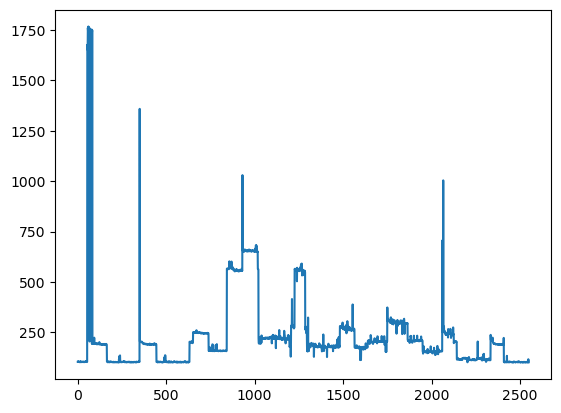

...
---------------------------------------------------------------------------
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
---------------------------------------------------------------------------
y_train
---------------------------------------------------------------------------
1st sample:  [ True  True  True  True  True  True False  True  True  True False  True
  True  True False]
2nd sample:  [False False False  True False False False  True False  True  True False
 False False False]
3rd sample:  [False False False False False False False False  True False False False
 False False False]
4th sample:  [False  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
...
---------------------------------------------------------------------------


In [30]:
print("---------------------------------------------------------------------------")
print("x_train")
print("---------------------------------------------------------------------------")
print("1st sample: ")
print("Time series: ")
print(x_train[0])
print("Plotted time series:")
plt.plot(x_train[0])
plt.show()
print("...")
print("---------------------------------------------------------------------------")
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("---------------------------------------------------------------------------")
print("y_train")
print("---------------------------------------------------------------------------")
print("1st sample: ", y_train[0])
print("2nd sample: ", y_train[1])
print("3rd sample: ", y_train[2])
print("4th sample: ", y_train[3])
print("...")
print("---------------------------------------------------------------------------")

## SE - Sensitivity Evaluation (Subsection V-C)

<p> With this code you generate the marked mixed dataset which has 15 DiT and 11 AD: </p>
<img src="./notebook_pics/heatmap_pic.png" alt="Alt Text" width="720"/>

In [46]:
window_size = 2550
nm_samples = 120_000

# EX: 15 DiT, 11 AD
DiT = 15 # Devices in Total (all devices in the household)
AD = 11  # Active Devices (devices in the household that are active)

# In the paper we generated 4 datasets for each of the blocks to get a more accurate score, 
# for the purpose of this demo we use only 1
nm_sets = 1

dict_list = subset_into_dict_list(processed_data, nm_sets, DiT, "UK-DALE")

for nm in range(0, nm_sets):
    x_train, x_test, y_train, y_test, labels = generate_xxyyl(dict_list, window_size, AD, nm, nm_samples)
    class_weights = class_weights_tool(y_test)

<strong>Example of Completed Datasets</strong>
<p>Upon completion of the code, the train and test datasets are expected to exhibit the following structure:</p>
<ol>
    <li> 
        <p><strong> x_train </strong> </p>
        <img src="./notebook_pics/x_train_SE.png" width="480"/>
    </li>
    <li> 
        <p><strong> y_train </strong> </p>
        <img src="./notebook_pics/y_train_SE.png" width="480"/>
    </li>
</ol>
<p>Within the datasets <code>x_train</code> and <code>x_test</code>, a time series of length 2550 is observed. Additionally, the datasets <code>y_train</code> and <code>y_test</code> contain arrays of 15 elements (because we have 15 DiT), each representing the device state. The elements are binary, where "True" indicates the device is ON, and "False" indicates the device is OFF. Fixed number of 11 active devices is in each of the samples.</p>

---------------------------------------------------------------------------
x_train
---------------------------------------------------------------------------
1st sample: 
Time series: 
[[85.]
 [85.]
 [86.]
 ...
 [68.]
 [67.]
 [72.]]
Plotted time series:


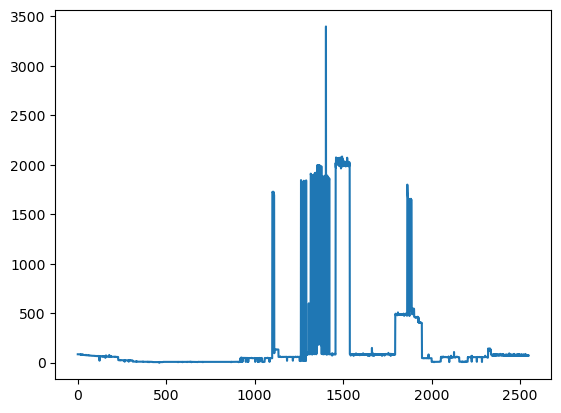

...
---------------------------------------------------------------------------
|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
---------------------------------------------------------------------------
y_train
---------------------------------------------------------------------------
1st sample:  [ True  True False False  True  True  True  True False  True  True  True
  True  True False]
2nd sample:  [ True  True  True False False  True  True  True  True  True False  True
 False  True  True]
3rd sample:  [False  True  True False  True  True  True False False  True  True  True
  True  True  True]
4th sample:  [ True False  True  True False  True  True  True  True  True False  True
  True  True False]
...
---------------------------------------------------------------------------


In [40]:
print("---------------------------------------------------------------------------")
print("x_train")
print("---------------------------------------------------------------------------")
print("1st sample: ")
print("Time series: ")
print(x_train[0])
print("Plotted time series:")
plt.plot(x_train[0])
plt.show()
print("...")
print("---------------------------------------------------------------------------")
print("|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||")
print("---------------------------------------------------------------------------")
print("y_train")
print("---------------------------------------------------------------------------")
print("1st sample: ", y_train[0])
print("2nd sample: ", y_train[1])
print("3rd sample: ", y_train[2])
print("4th sample: ", y_train[3])
print("...")
print("---------------------------------------------------------------------------")

# Training & Evaluation

## RE - Realistic Evaluation

<p> This example corresponds to this cell in the heatmap: </p>
<img src="./notebook_pics/R_heatmap_pic.png" width="180"/>

In [50]:
BS = 128
LR = 0.0003
E = 20

DiT = 15
window_size = 2550

# Using the saved dataset
#saved_dataset = pickle.load(open('path','rb'))
#x_train, x_test, y_train, y_test, labels = saved_dataset[0], saved_dataset[1], saved_dataset[2], saved_dataset[3], saved_dataset[4]
class_weights = class_weights_tool(y_test)

# |||||||||||||||||||||||||||||||| training ||||||||||||||||||||||||||||||||
model = CtRNN(DiT, window_size)
model.build((len(y_train) + len(y_test), window_size, 1))
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = [F1Score])
model.fit(x_train, y_train, batch_size = BS, epochs = E, class_weight = class_weights)
# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)
# |||||||||||||||||||||||||||||||| evaluation ||||||||||||||||||||||||||||||||
print(metrics.classification_report(y_test, y_pred_tf, target_names = labels, zero_division = 0))

Epoch 1/20
750/750 [==============================] - 32s 39ms/step - loss: inf - F1Score: 0.7531
Epoch 2/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8174
Epoch 3/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8334
Epoch 4/20
750/750 [==============================] - 27s 36ms/step - loss: inf - F1Score: 0.8439
Epoch 5/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8520
Epoch 6/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8585
Epoch 7/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8634
Epoch 8/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8681
Epoch 9/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8721
Epoch 10/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8755
Epoch 11/20
750/750

## SE - Sensitivity Evaluation

<p> This example corresponds to this cell in the heatmap: </p>

<img src="./notebook_pics/heatmap_pic.png" width="480"/>

In [47]:
# Parameters according to the Table 2 in our paper.
BS = 128
LR = 0.0005
E = 20

# |||||||||||||||||||||||||||||||| training ||||||||||||||||||||||||||||||||
model = CtRNN(DiT, window_size)
model.build((len(y_train) + len(y_test), window_size, 1))
#model.summary()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR), loss = 'binary_crossentropy', metrics = [F1Score])
model.fit(x_train, y_train, batch_size = BS, epochs = E, class_weight = class_weights)

# |||||||||||||||||||||||||||||||| prediction ||||||||||||||||||||||||||||||||
y_pred = model.predict(x_test)
y_pred_tf = (y_pred > 0.5)

# |||||||||||||||||||||||||||||||| evaluation ||||||||||||||||||||||||||||||||
print(metrics.classification_report(y_test, y_pred_tf, target_names = labels, zero_division = 0))

Epoch 1/20
750/750 [==============================] - 30s 36ms/step - loss: inf - F1Score: 0.8564
Epoch 2/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8782
Epoch 3/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8854
Epoch 4/20
750/750 [==============================] - 26s 34ms/step - loss: inf - F1Score: 0.8903
Epoch 5/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8934
Epoch 6/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.8965
Epoch 7/20
750/750 [==============================] - 26s 34ms/step - loss: inf - F1Score: 0.8993
Epoch 8/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.9017
Epoch 9/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.9035
Epoch 10/20
750/750 [==============================] - 26s 35ms/step - loss: inf - F1Score: 0.9056
Epoch 11/20
750/750